# SARIMA MODEL

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

### Load Libraries and DataSet

In [63]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

In [64]:
def load_store(store_id):
  """Loads from the project root directory"""
  return pd.read_pickle(f"./StoreID_{store_id}.pickle")

In [65]:
store_01_df = load_store('0')
store_01_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,d_1,0,11101,Saturday,...,1,2011,30,4,4,2,0,0,0,NaN
2011-01-29,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,d_1,0,11101,Saturday,...,1,2011,30,4,4,2,0,0,0,NaN
2011-01-29,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,d_1,0,11101,Saturday,...,1,2011,30,4,4,2,0,0,0,NaN
2011-01-29,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,d_1,0,11101,Saturday,...,1,2011,30,4,4,2,0,0,0,NaN
2011-01-29,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,d_1,0,11101,Saturday,...,1,2011,30,4,4,2,0,0,0,NaN


In [66]:
store_01_df['sell_price'] = store_01_df['sell_price'].fillna(-1)

### Select HOBBIES_1_001_CA_1_validation Time Series

In [67]:
TS_1437 = store_01_df.loc[store_01_df['item_id'] == 1437]

### Split data into Endog and Exog

- **Endogenous Regressor** equal to the number of product sold on each day.  It's value is determined by the model.
- **Exogenous Regressor** equal to the different events and SNAP values.  It's value is determined outside of the model.

In [68]:
X_train = TS_1437.iloc[:,13:20].astype(np.float32)
y_train = TS_1437['sold'].astype(np.float32)

In [69]:
X_train

,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
date,,,,,,,
2011-01-29,30.0,4.0,4.0,2.0,0.0,0.0,0.0
2011-01-30,30.0,4.0,4.0,2.0,0.0,0.0,0.0
2011-01-31,30.0,4.0,4.0,2.0,0.0,0.0,0.0
2011-02-01,30.0,4.0,4.0,2.0,1.0,1.0,0.0
2011-02-02,30.0,4.0,4.0,2.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...
2016-04-20,30.0,4.0,4.0,2.0,0.0,0.0,0.0
2016-04-21,30.0,4.0,4.0,2.0,0.0,0.0,0.0
2016-04-22,30.0,4.0,4.0,2.0,0.0,0.0,0.0


### Select Best Values for PDQ

Selects the Best Order and Seasonal Order for our model by finding the combination that has the lowest Root Mean Squared Error

**ARIMA Order**
- p: Trend autoregression order
- d: Trend difference order
- q: Trend moving average order

**Seasonal Order**
- sp: Seasonal autoregressive order.
- sq: Seasonal difference order.
- sd: Seasonal moving average order.
- m: The number of time steps for a single seasonal period. (**7 for daily**)

In [70]:
%%time
# Parameter Optimization
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools as itr

p = [1]
q = [0, 1]
d = [0, 1]
pdq = list(itr.product(p, d, q))
sp = [0, 1]
sq = [0, 1]
sd = [0, 1]
s = [7]
seasonal_pdq = list(itr.product(sp, sd, sq,s))
pattern = len(seasonal_pdq) * len(pdq)

warnings.filterwarnings('ignore')

modelSelection = pd.DataFrame(index=range(pattern), columns=["model", "aic",'rmse'])
num = 0
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mdl = SARIMAX(endog=y_train, exog=X_train,
                                   order=param, seasonal_order=param_seasonal, measurement_error = True,
                                   enforce_stationarity = False, enforce_invertibility = False).fit()
        modelSelection["model"][num] = "order=(" + str(param) + "), season=("+ str(param_seasonal) + ")"
        modelSelection["aic"][num] = mdl.aic
        
        pred = mdl.predict(start=1, end=len(X_train), exog=X_train.iloc[0,:]) 
        pred[pred < 0] = 0
        modelSelection["rmse"][num] = np.sqrt(metrics.mean_squared_error(y_train, pred))
        
        num = num + 1
        
# RMSE Minimum
modelSelection[modelSelection.rmse == min(modelSelection.rmse)]

Wall time: 6min 26s


,model,aic,rmse
29,"order=((1, 1, 1)), season=((1, 0, 1, 7))",3575.37,0.587978


                                     SARIMAX Results                                     
Dep. Variable:                              sold   No. Observations:                 1913
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -1774.683
Date:                           Tue, 30 Jun 2020   AIC                           3575.366
Time:                                   12:23:35   BIC                           3647.531
Sample:                               01-29-2011   HQIC                          3601.930
                                    - 04-24-2016                                         
Covariance Type:                             opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
event_name_1              0.0078      0.005      1.505      0.132      -0.002       0.018
event_type

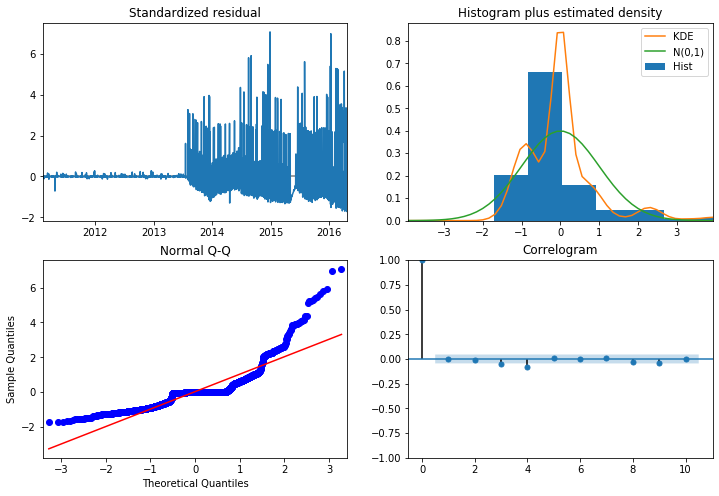

In [71]:
warnings.filterwarnings('ignore')

mdl = SARIMAX(endog=y_train, exog=X_train,
                            order=(1,1,1), seasonal_order=(1,0,1,7), measurement_error = True,
                            enforce_stationarity=False,enforce_invertibility=False)
results = mdl.fit()
results.plot_diagnostics(figsize=(12,8))
print(results.summary())

### Evaluate Model with Best Parameters

In [72]:
ItemID = 'HOBBIES_1_001_CA_1_validation'

In [73]:
#evaluation test
def evaluation_test(actual, predict, title):
    from sklearn import metrics
    from scipy.stats import pearsonr
    rmse = np.sqrt(metrics.mean_squared_error(actual, predict))
    corr, p = pearsonr(actual, predict)
    print(title, '; RMSE is ', rmse, ',  Correlation is ', corr)

y_pred = results.predict(start=1, end=len(X_train), exog=X_train.iloc[0,:]) 
y_pred[y_pred < 0] = 0
evaluation_test(y_train, y_pred, ItemID)

HOBBIES_1_001_CA_1_validation ; RMSE is  0.5879781274057387 ,  Correlation is  0.5189253809397931
